In [1]:
import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords

from wordcloud import WordCloud 

from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
import sklearn.metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import string

from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

# Data preparation

In [3]:
# Importazione dataset e riconversione colonna in lista di stringhe, come già fatto nel preprocessing

df = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_lemmatized.csv')
df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

In [4]:
# Mantengo solo le colonne necessarie al clustering

clust_df = df[['Lemmatized Text', 'Score']]

In [5]:
clust_df.head()

Lemmatized Text  Score
0  [bought, several, vitality, canned, dog, food,...      5
1  [product, arrived, labelled, lumbo, halted, pe...      1
2  [connection, around, century, light, pillow, c...      4
3  [looking, secret, ingredient, robitussin, beli...      2
4  [great, staff, great, price, wide, assortment,...      5

Sappiamo che le review sono sbilanciate verso la classe '4' e '5': procedo al downsampling.

Text(0, 0.5, 'Number of reviews')

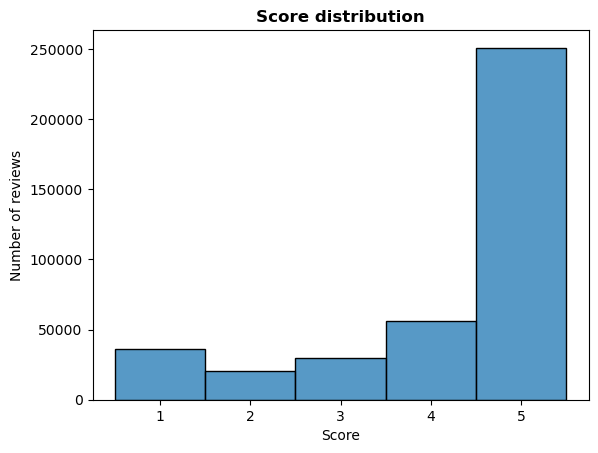

In [6]:
sns.histplot(clust_df['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [7]:
sample_size = clust_df.groupby('Score').count().min()[0] # Prendo come dimensione quella minima fra tutte le classi

df_downsampled = clust_df.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size))
df_downsampled

Lemmatized Text  Score
24199   [idea, crime, rule, coffee, sounded, delicious...      1
280493  [placed, order, beginning, year, treat, grown,...      1
334394  [cant, believe, made, package, human, consumpt...      1
14046   [coffee, good, every, cup, broke, use, making,...      1
382506  [good, sweet, loaded, fat, calorie, barely, ev...      1
...                                                   ...    ...
307750  [love, carousal, like, box, smashed, drawer, i...      5
9596    [low, care, diet, pork, kind, natural, bought,...      5
373416  [loved, bag, breastfeeding, much, better, lans...      5
153457  [absolutely, love, product, reason, none, loca...      5
241331  [say, organic, wheat, free, mummy, sweet, yet,...      5

[104010 rows x 2 columns]

Text(0, 0.5, 'Number of reviews')

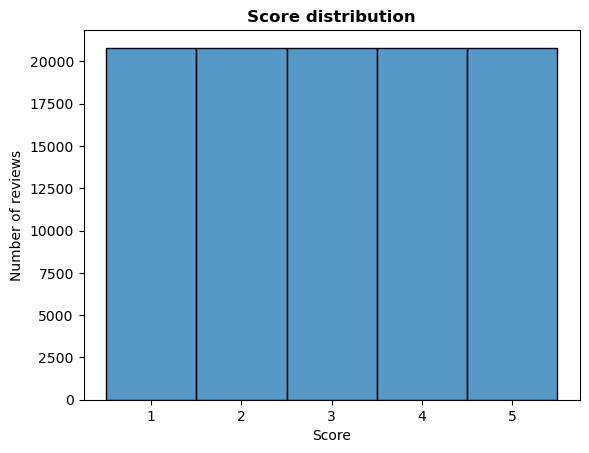

In [8]:
sns.histplot(df_downsampled['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [9]:
# Eseguo uno shuffle dei dati

df_4_clustering = shuffle(df_downsampled, random_state = 123)
df_4_clustering.reset_index(drop=True, inplace=True)
df_4_clustering.head()

Lemmatized Text  Score
0  [stick, steel, cut, oat, space, typically, lov...      1
1  [update, receiving, order, first, review, shim...      2
2  [murphy, softcoated, heaven, merrier, love, tr...      5
3  [bought, chocolate, whole, food, dismounted, p...      4
4  [found, healthy, choice, soup, good, soup, mic...      2

In [10]:
# Divido x e y

x_clust = df_4_clustering['Lemmatized Text']
y_clust = df_4_clustering['Score']

In [12]:
# Dal momento che l'agglomerative clustering è molto più dispendioso riduco la dimensione dei dati usati in quel caso

df_4_agglomerative = df_4_clustering.groupby('Score', group_keys=False).apply(lambda x: x.sample(2000))
df_4_agglomerative = shuffle(df_4_agglomerative, random_state = 123)
df_4_agglomerative.reset_index(drop=True, inplace=True)
df_4_agglomerative

Lemmatized Text  Score
0     [werent, great, funny, aftertaste, probably, w...      2
1     [never, tried, product, ever, looking, purchas...      1
2     [looking, one, sam, sometimes, ago, returned, ...      5
3     [ingredient, list, say, montmorencys, part, th...      1
4     [expecting, paste, type, mix, tuffier, dry, mi...      3
...                                                 ...    ...
9995  [previously, thought, dis, vanilla, granular, ...      5
9996  [one, friend, chocolate, looking, interesting,...      4
9997  [concept, muster, cure, great, make, getting, ...      3
9998  [recently, purchased, box, candy, see, three, ...      1
9999  [purchased, china, seed, realize, said, oz, wo...      2

[10000 rows x 2 columns]

In [13]:
x_clust_agg = df_4_agglomerative['Lemmatized Text']
y_clust_agg = df_4_agglomerative['Score']

# Clustering

## BOW

In [11]:
cv = CountVectorizer(min_df=0., max_df=1.0)
cv_model = cv.fit(x_clust.astype(str)) 
x_clust_BOW = cv_model.transform(x_clust.astype(str))

In [12]:
tSVD_BOW = TruncatedSVD(n_components = 1000)
SVD_BOW = tSVD_BOW.fit(x_clust_BOW)
x_clust_BOW = tSVD_BOW.transform(x_clust_BOW)
print(SVD_BOW.explained_variance_ratio_.sum())

0.7976147634000178


In [ ]:
# Normalizzo i dati

# x_clust_BOW_norm = preprocessing.normalize(x_clust_BOW)

### K-means

**Elbow method**: per individuare il numero ottimale di cluster, uno dei modi più utilizzati è quello di valuate l'inertia vs. n_cluster e considerare come numero ottimale quello che corrisponde all'**elbow point**.

https://towardsdatascience.com/clustering-how-to-find-hyperparameters-using-inertia-b0343c6fe819

L'inertia è definita come:

$\sum_{i=1}^N (x_i-C_k)^2$

dove N è il numero di campioni nel dataset e $C_k$ è il centroide del cluster. L'inertia, quindi, è la somma della distanza di ciascun dato del dataset dal centroide del cluster a cui appartiene: tale somma va minimizzata.

In [29]:
k=[2,3,4,5,6,7,8]
bow_inertia=[]
bow_silhouette_scores = []
bow_calinski_score = []
bow_davies_score = []
for i in k:
    model=KMeans(n_clusters=i, random_state=123)
    labels = model.fit_predict(x_clust_BOW)
    bow_inertia.append(model.inertia_)
    bow_silhouette_scores.append(sklearn.metrics.silhouette_score(x_clust_BOW, labels))
    bow_calinski_score.append(sklearn.metrics.calinski_harabasz_score(x_clust_BOW, labels))
    bow_davies_score.append(sklearn.metrics.davies_bouldin_score(x_clust_BOW, labels))
    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete


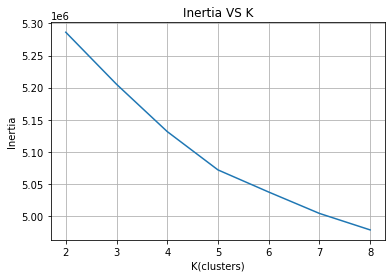

In [30]:
plt.plot(k, bow_inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K')
plt.grid()
plt.show()

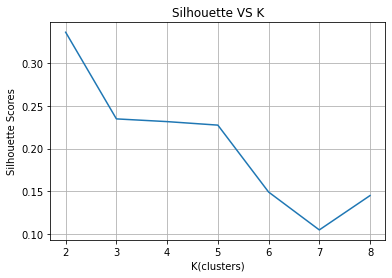

In [31]:
plt.plot(k, bow_silhouette_scores)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

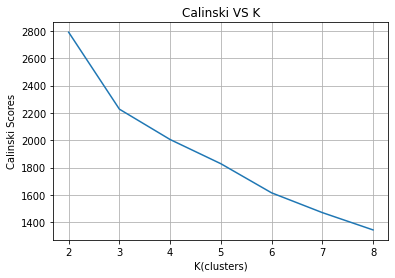

In [32]:
plt.plot(k, bow_calinski_score)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

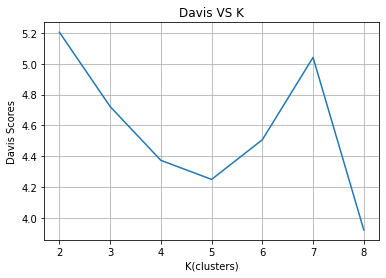

In [33]:
plt.plot(k, bow_davies_score)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

Guardando le diverse metriche si nota che l'elbow è a k=5. Il coefficiente di Silhouette è massimo a k=2 (cosa che suggerisce che probabilmente non ci sono cluster ben definiti nel dataset, cosa per altro sostenuta anche dai valori dei coefficienti di Silhouette) ma i valori a k=3, k=4, k=5 sono tutti molto simili. Davies ha un minimo a 5, mentre per Calinski non è immediato individuare il numero corretto di cluster. Si procede, quindi, per k=5.

In [42]:
# Scelto il k ottimale, definisco il clustering

k_means_bow = KMeans(n_clusters=5, max_iter=20, n_init=10, random_state=123)
labels_bow = k_means_bow.fit_predict(x_clust_BOW)

In [43]:
# Performance modello di clustering

print(k_means_bow.inertia_)
print(sklearn.metrics.silhouette_score(x_clust_BOW, labels_bow))
print(sklearn.metrics.calinski_harabasz_score(x_clust_BOW, labels_bow))
print(sklearn.metrics.davies_bouldin_score(x_clust_BOW, labels_bow))

5067623.929560447
0.22334189463376858
1821.1156649641557
4.274095466734889


In [52]:
# Creo delle liste contenete gli elementi dei vari cluster, così da fare delle word cloud e analisi specifiche per cluster

bow_cluster1,bow_cluster2,bow_cluster3,bow_cluster4,bow_cluster5=[],[],[],[],[]
for i in range(k_means_bow.labels_.shape[0]):
    if k_means_bow.labels_[i] == 0:
        bow_cluster1.append(x_clust[i])
    elif k_means_bow.labels_[i] == 1:
        bow_cluster2.append(x_clust[i])
    elif k_means_bow.labels_[i] == 2:
        bow_cluster3.append(x_clust[i])
    elif k_means_bow.labels_[i] == 3:
        bow_cluster4.append(x_clust[i])
    else:
        bow_cluster5.append(x_clust[i])

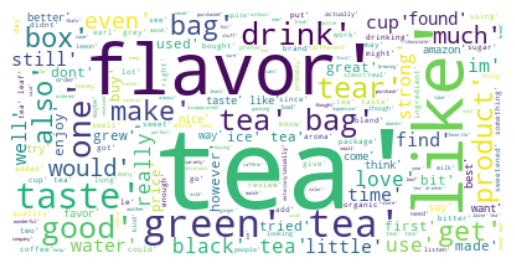

In [53]:
# Cluster 1
data=''
for i in bow_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

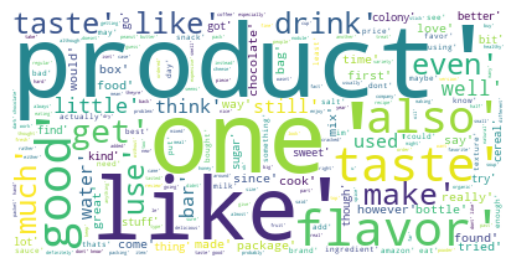

In [54]:
# Cluster 2
data=''
for i in bow_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

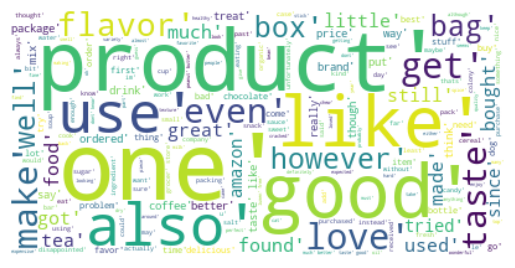

In [55]:
# Cluster 3
data=''
for i in bow_cluster3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

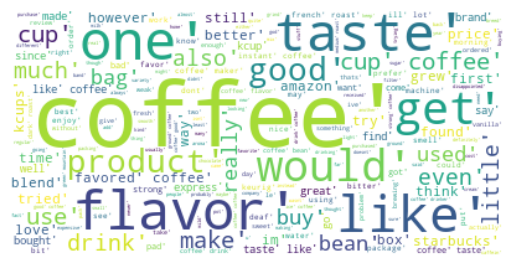

In [56]:
# Cluster 4
data=''
for i in bow_cluster4:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

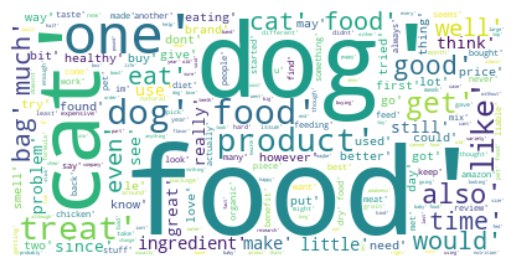

In [57]:
# Cluster 5
data=''
for i in bow_cluster5:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [58]:
cluster_list = [bow_cluster1, bow_cluster2, bow_cluster3, bow_cluster4, bow_cluster5]
print("Top 5 terms per cluster:")
for i in range(5):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: tea like taste flavor green
Cluster 2: like taste product one good
Cluster 3: taste product like good one
Cluster 4: coffee like taste cup flavor
Cluster 5: food dog cat like treat


### Agglomerative clustering

In [14]:
cv_agg = CountVectorizer(min_df=0., max_df=1.0)
cv_model_agg = cv_agg.fit(x_clust_agg.astype(str)) 
x_agg_BOW = cv_model_agg.transform(x_clust_agg.astype(str))

In [15]:
tSVD_BOW_agg = TruncatedSVD(n_components = 1000)
SVD_BOW_agg = tSVD_BOW_agg.fit(x_agg_BOW)
x_agg_BOW = tSVD_BOW_agg.transform(x_agg_BOW)
print(SVD_BOW_agg.explained_variance_ratio_.sum())

0.8514224198903095


In [16]:
k=[2,3,4,5]
bow_silhouette_scores_agg = []
bow_calinski_score_agg = []
bow_davies_score_agg = []
for i in k:
    agg=AgglomerativeClustering(n_clusters=i)
    labels = agg.fit_predict(x_agg_BOW)
    bow_silhouette_scores_agg.append(sklearn.metrics.silhouette_score(x_agg_BOW, labels))
    bow_calinski_score_agg.append(sklearn.metrics.calinski_harabasz_score(x_agg_BOW, labels))
    bow_davies_score_agg.append(sklearn.metrics.davies_bouldin_score(x_agg_BOW, labels))
    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete


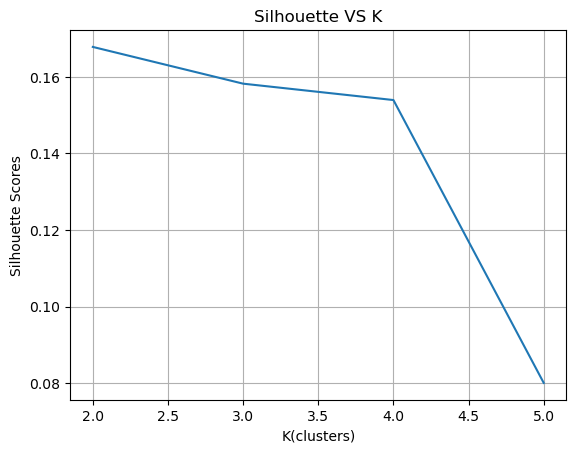

In [17]:
plt.plot(k, bow_silhouette_scores_agg)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

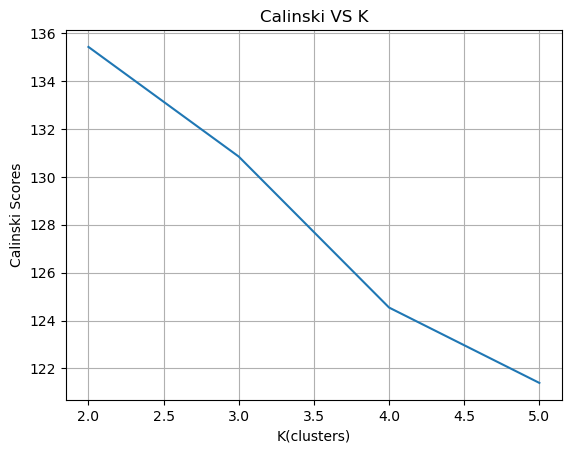

In [18]:
plt.plot(k, bow_calinski_score_agg)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

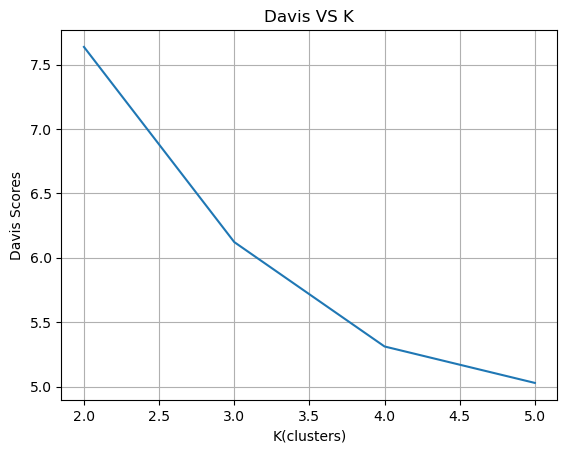

In [19]:
plt.plot(k, bow_davies_score_agg)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

In [20]:
# Scelto il k ottimale, definisco il clustering

agg_bow = AgglomerativeClustering(n_clusters=4)
labels_bow_agg = agg_bow.fit_predict(x_agg_BOW)

print(sklearn.metrics.silhouette_score(x_agg_BOW, labels_bow_agg))
print(sklearn.metrics.calinski_harabasz_score(x_agg_BOW, labels_bow_agg))
print(sklearn.metrics.davies_bouldin_score(x_agg_BOW, labels_bow_agg))

0.15394195387088513
124.54356958794189
5.310851096392148


In [24]:
agg_bow_1,agg_bow_2,agg_bow_3,agg_bow_4=[],[],[],[]
for i in range(agg_bow.labels_.shape[0]):
    if agg_bow.labels_[i] == 0:
        agg_bow_1.append(x_clust_agg[i])
    elif agg_bow.labels_[i] == 1:
        agg_bow_2.append(x_clust_agg[i])
    elif agg_bow.labels_[i] == 2:
        agg_bow_3.append(x_clust_agg[i])
    else:
        agg_bow_4.append(x_clust_agg[i])

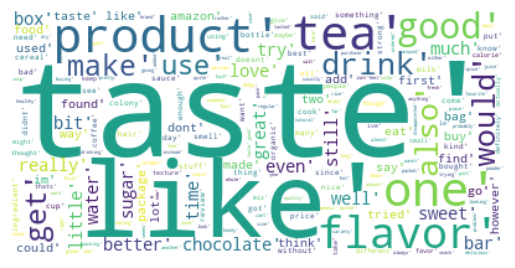

In [25]:
# Cluster 1
data=''
for i in agg_bow_1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

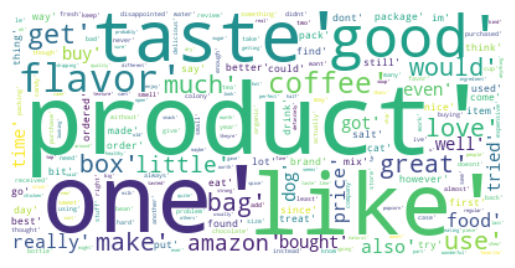

In [26]:
# Cluster 2
data=''
for i in agg_bow_2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

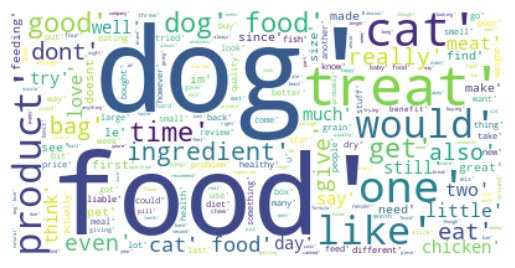

In [27]:
# Cluster 3
data=''
for i in agg_bow_3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

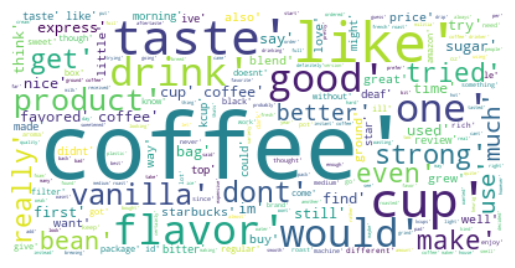

In [28]:
# Cluster 4
data=''
for i in agg_bow_4:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
cluster_list = [agg_bow_1, agg_bow_2, agg_bow_3, agg_bow_4]
print("Top 5 terms per cluster:")
for i in range(4):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: like taste tea good one
Cluster 2: product taste like good one
Cluster 3: food dog treat cat one
Cluster 4: coffee like cup taste flavor


## TF-IDF

In [21]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model = tv.fit(x_clust.astype(str))
x_clust_TFIDF = tv.transform(x_clust.astype(str))

In [22]:
tSVD_TFIDF = TruncatedSVD(n_components = 1000)
SVD_TFIDF = tSVD_TFIDF.fit(x_clust_TFIDF)
x_clust_TFIDF = tSVD_TFIDF.transform(x_clust_TFIDF)
print(SVD_TFIDF.explained_variance_ratio_.sum())

0.5639025791316314


In [ ]:
# Normalizzo i dati

# x_clust_TFIDF_norm = preprocessing.normalize(x_clust_TFIDF)

### K-means

In [21]:
k=[2,3,4,5,6,7,8]
tf_inertia=[]
tf_silhouette_scores = []
tf_calinski_score = []
tf_davies_score = []
for i in k:
    model=KMeans(n_clusters=i, random_state=123)
    labels = model.fit_predict(x_clust_TFIDF)
    tf_inertia.append(model.inertia_)
    tf_silhouette_scores.append(sklearn.metrics.silhouette_score(x_clust_TFIDF, labels))
    tf_calinski_score.append(sklearn.metrics.calinski_harabasz_score(x_clust_TFIDF, labels))
    tf_davies_score.append(sklearn.metrics.davies_bouldin_score(x_clust_TFIDF, labels))
    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete


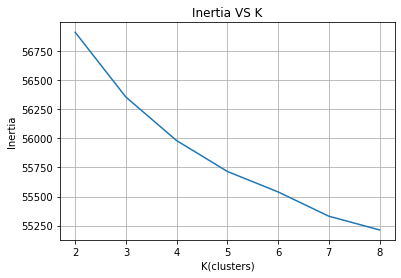

In [22]:
plt.plot(k, tf_inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K')
plt.grid()
plt.show()

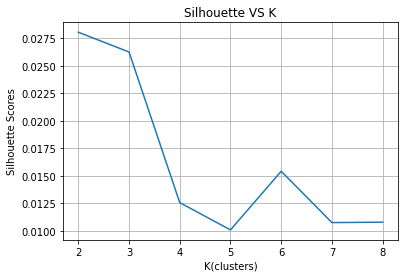

In [23]:
plt.plot(k, tf_silhouette_scores)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

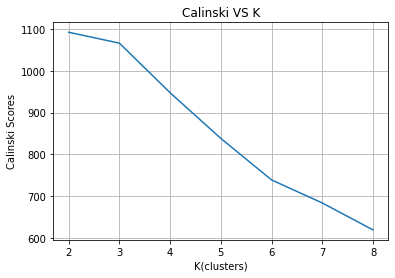

In [24]:
plt.plot(k, tf_calinski_score)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

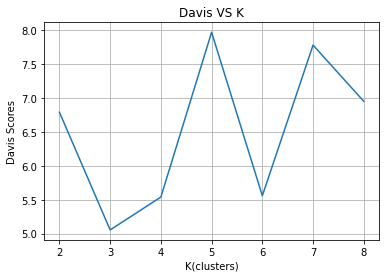

In [25]:
plt.plot(k, tf_davies_score)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

In questo caso, per quanto l'elbow è a k=4, il coefficiente di Silhouette e lo score di Davies sono, rispettivamente, massimizzato e minimizzato in k=3. Anche Calinski in k=3 presenta un vertice più pronunciato rispetto agli altri k. In questo caso, quindi, si sceglie k=3.

In [23]:
# Scelto il k ottimale, definisco il clustering

k_means_tf = KMeans(n_clusters=3, max_iter=20, n_init=10, random_state=123)
labels_tf = k_means_tf.fit_predict(x_clust_TFIDF)

In [24]:
# Performance modello di clustering

print(k_means_tf.inertia_)
print(sklearn.metrics.silhouette_score(x_clust_TFIDF, labels_tf))
print(sklearn.metrics.calinski_harabasz_score(x_clust_TFIDF, labels_tf))
print(sklearn.metrics.davies_bouldin_score(x_clust_TFIDF, labels_tf))

56291.33733465323
0.026667480469992396
1071.4744518286413
5.084042169218741


In [25]:
tf_cluster1,tf_cluster2,tf_cluster3=[],[],[]
for i in range(k_means_tf.labels_.shape[0]):
    if k_means_tf.labels_[i] == 0:
        tf_cluster1.append(x_clust[i])
    elif k_means_tf.labels_[i] == 1:
        tf_cluster2.append(x_clust[i])
    else:
        tf_cluster3.append(x_clust[i])

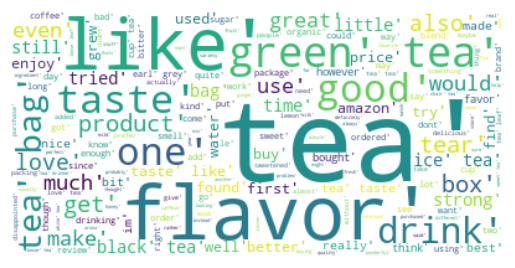

In [26]:
# Cluster 1
data=''
for i in tf_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

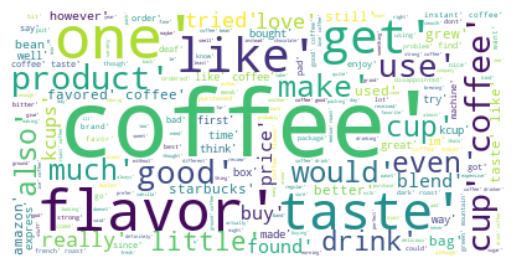

In [27]:
# Cluster 2
data=''
for i in tf_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

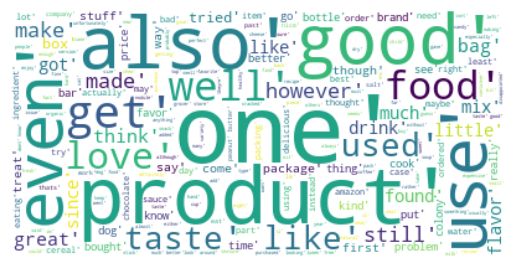

In [28]:
# Cluster 3
data=''
for i in tf_cluster3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
cluster_list = [tf_cluster1, tf_cluster2, tf_cluster3]
print("Top 5 terms per cluster:")
for i in range(3):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: tea taste like flavor good
Cluster 2: coffee like taste cup flavor
Cluster 3: like taste product good one


### Agglomerative clustering

In [30]:
tv_agg = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model_agg = tv_agg.fit(x_clust_agg.astype(str))
x_agg_TFIDF = tv_model_agg.transform(x_clust_agg.astype(str))

In [32]:
tSVD_TFIDF_agg = TruncatedSVD(n_components = 1000)
SVD_TFIDF_agg = tSVD_TFIDF_agg.fit(x_agg_TFIDF)
x_agg_TFIDF = tSVD_TFIDF_agg.transform(x_agg_TFIDF)
print(SVD_TFIDF_agg.explained_variance_ratio_.sum())

0.6317755809034873


In [33]:
k=[2,3,4,5]
TFIDF_silhouette_scores_agg = []
TFIDF_calinski_score_agg = []
TFIDF_davies_score_agg = []
for i in k:
    agg=AgglomerativeClustering(n_clusters=i)
    labels = agg.fit_predict(x_agg_TFIDF)
    TFIDF_silhouette_scores_agg.append(sklearn.metrics.silhouette_score(x_agg_TFIDF, labels))
    TFIDF_calinski_score_agg.append(sklearn.metrics.calinski_harabasz_score(x_agg_TFIDF, labels))
    TFIDF_davies_score_agg.append(sklearn.metrics.davies_bouldin_score(x_agg_TFIDF, labels))
    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete


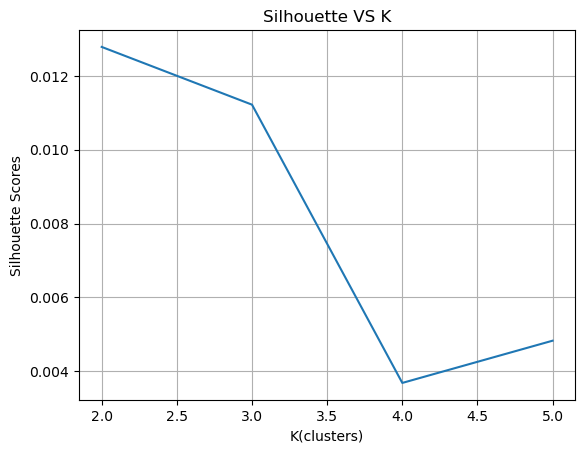

In [34]:
plt.plot(k, TFIDF_silhouette_scores_agg)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

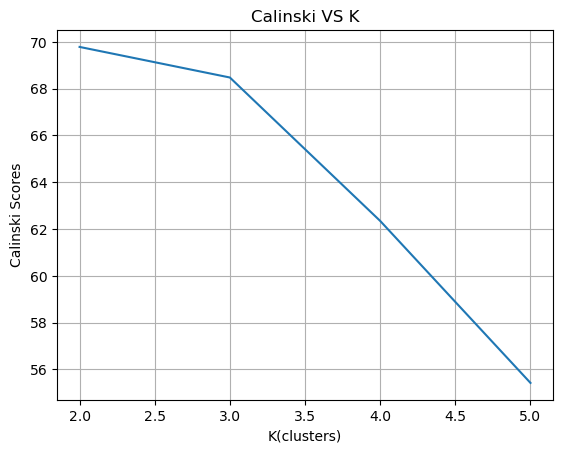

In [35]:
plt.plot(k, TFIDF_calinski_score_agg)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

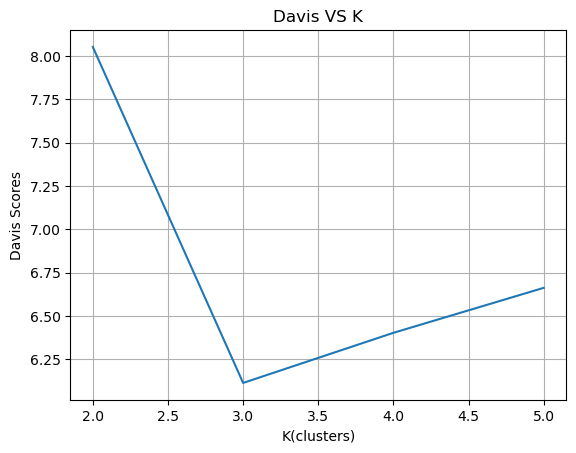

In [36]:
plt.plot(k, TFIDF_davies_score_agg)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

In [37]:
# Scelto il k ottimale, definisco il clustering

agg_TFIDF = AgglomerativeClustering(n_clusters=3)
labels_TFIDF_agg = agg_TFIDF.fit_predict(x_agg_TFIDF)

print(sklearn.metrics.silhouette_score(x_agg_TFIDF, labels_TFIDF_agg))
print(sklearn.metrics.calinski_harabasz_score(x_agg_TFIDF, labels_TFIDF_agg))
print(sklearn.metrics.davies_bouldin_score(x_agg_TFIDF, labels_TFIDF_agg))

0.011221915107252576
68.47463034165861
6.114731147078943


In [38]:
agg_TFIDF_1,agg_TFIDF_2,agg_TFIDF_3=[],[],[]
for i in range(agg_TFIDF.labels_.shape[0]):
    if agg_TFIDF.labels_[i] == 0:
        agg_TFIDF_1.append(x_clust_agg[i])
    elif agg_TFIDF.labels_[i] == 1:
        agg_TFIDF_2.append(x_clust[i])
    else:
        agg_TFIDF_3.append(x_clust_agg[i])

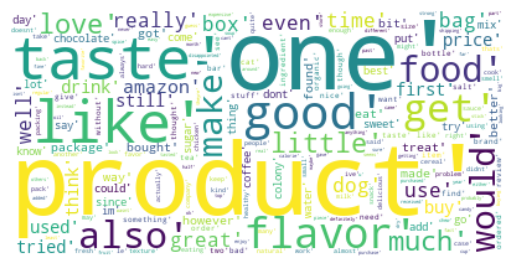

In [39]:
# Cluster 1
data=''
for i in agg_TFIDF_1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

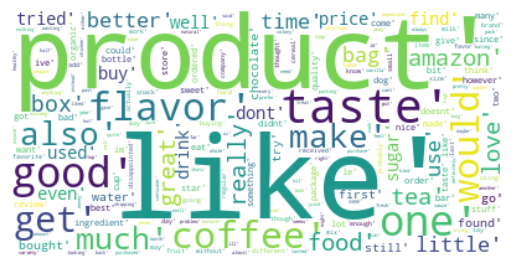

In [40]:
# Cluster 2
data=''
for i in agg_TFIDF_2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

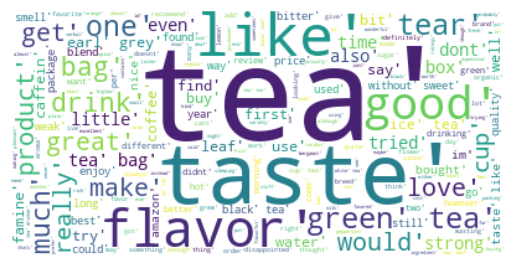

In [41]:
# Cluster 3
data=''
for i in agg_TFIDF_3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
cluster_list = [agg_TFIDF_1, agg_TFIDF_2,agg_TFIDF_3]
print("Top 5 terms per cluster:")
for i in range(3):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: like taste product good one
Cluster 2: like taste product good one
Cluster 3: tea like taste flavor green


## W2V

In [30]:
w2v_model = gensim.models.Word2Vec(x_clust, vector_size=300, window=8, min_count=2)
words = set(w2v_model.wv.index_to_key)

In [31]:
x_clust_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in x_clust])

In [32]:
x_clust_avg = []
for v in x_clust_vect:
    if v.size:
        x_clust_avg.append(v.mean(axis=0))
    else:
        x_clust_avg.append(np.zeros(300, dtype=float))

In [ ]:
# Normalizzo i dati

# x_clust_avg_norm = preprocessing.normalize(x_clust_avg)

### K-means

In [14]:
k=[2,3,4,5,6,7,8]
w2v_inertia=[]
w2v_silhouette_scores = []
w2v_calinski_score = []
w2v_davies_score = []
for i in k:
    model=KMeans(n_clusters=i, random_state=123)
    labels = model.fit_predict(x_clust_avg)
    w2v_inertia.append(model.inertia_)
    w2v_silhouette_scores.append(sklearn.metrics.silhouette_score(x_clust_avg, labels))
    w2v_calinski_score.append(sklearn.metrics.calinski_harabasz_score(x_clust_avg, labels))
    w2v_davies_score.append(sklearn.metrics.davies_bouldin_score(x_clust_avg, labels))

    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete


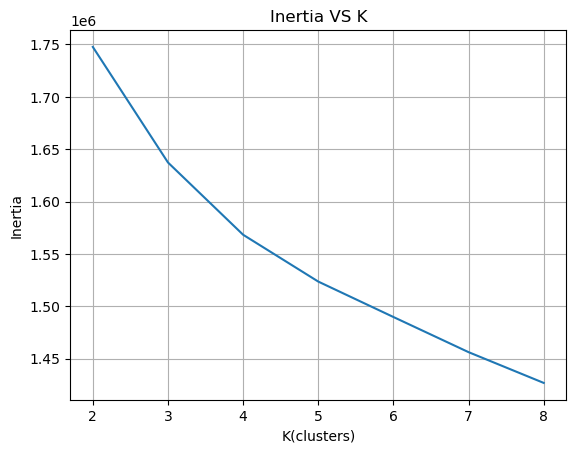

In [15]:
plt.plot(k, w2v_inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K')
plt.grid()
plt.show()

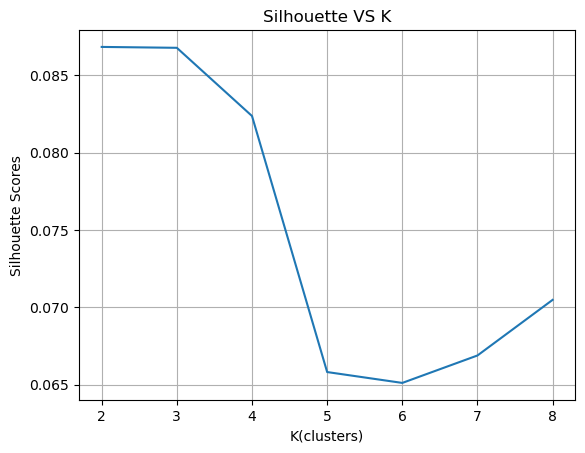

In [16]:
plt.plot(k, w2v_silhouette_scores)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

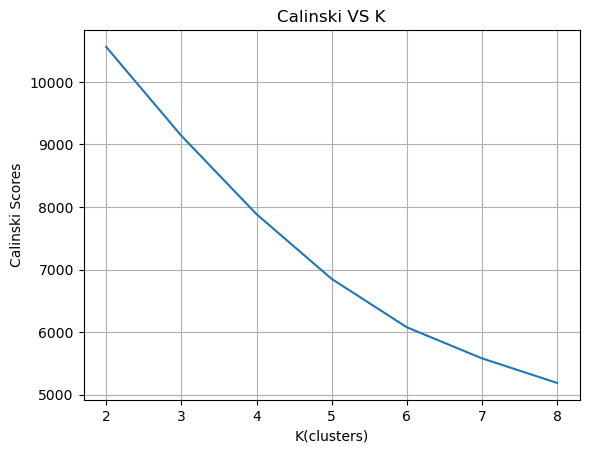

In [17]:
plt.plot(k, w2v_calinski_score)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

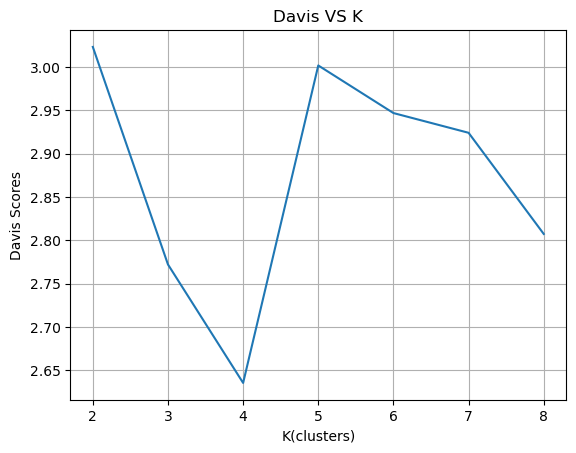

In [18]:
plt.plot(k, w2v_davies_score)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

In questo caso a guidare la scelta sono specialmente Silhouette (i cui valori, comunque sono molto vicini a 0) e Davies che mostrano come, probabilmente, il numero ottimale di cluster sia k=4.

In [33]:
# Scelto il k ottimale, definisco il clustering

k_means_w2v = KMeans(n_clusters=4, max_iter=20, n_init=10, random_state=123)
labels_w2v = k_means_w2v.fit_predict(x_clust_avg)

In [34]:
# Performance modello di clustering

print(k_means_w2v.inertia_)
print(sklearn.metrics.silhouette_score(x_clust_avg, labels_w2v))
print(sklearn.metrics.calinski_harabasz_score(x_clust_avg, labels_w2v))
print(sklearn.metrics.davies_bouldin_score(x_clust_avg, labels_w2v))

1570412.6538235196
0.08086216646778188
7794.9993222409485
2.6544993776384276


In [35]:
w2v_cluster1,w2v_cluster2,w2v_cluster3,w2v_cluster4=[],[],[],[]
for i in range(k_means_w2v.labels_.shape[0]):
    if k_means_w2v.labels_[i] == 0:
        w2v_cluster1.append(x_clust[i])
    elif k_means_w2v.labels_[i] == 1:
        w2v_cluster2.append(x_clust[i])
    elif k_means_w2v.labels_[i] == 2:
        w2v_cluster3.append(x_clust[i])
    else:
        w2v_cluster4.append(x_clust[i])

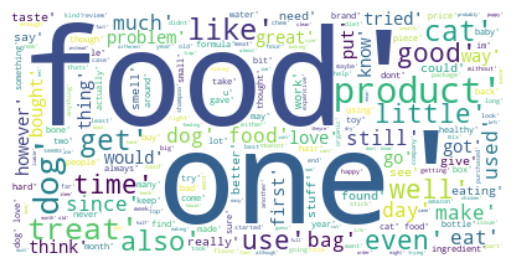

In [36]:
# Cluster 1
data=''
for i in w2v_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

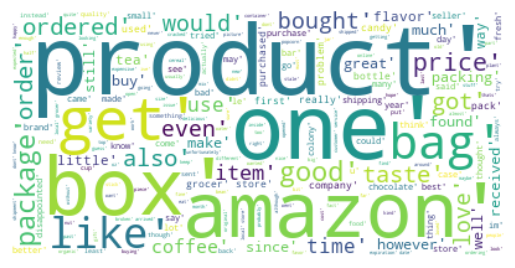

In [37]:
# Cluster 2
data=''
for i in w2v_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

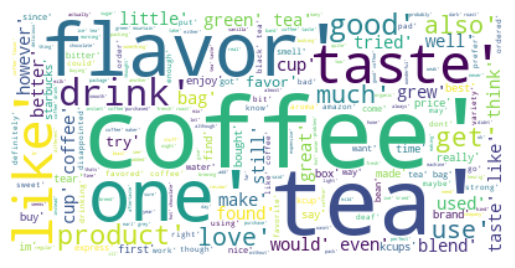

In [38]:
# Cluster 3
data=''
for i in w2v_cluster3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

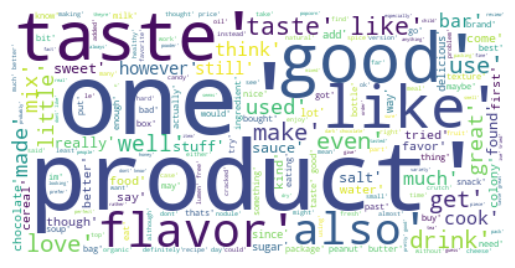

In [39]:
# Cluster 4
data=''
for i in w2v_cluster4:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [40]:
cluster_list = [w2v_cluster1, w2v_cluster2, w2v_cluster3, w2v_cluster4]
print("Top 5 terms per cluster:")
for i in range(4):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: dog food like product cat
Cluster 2: product amazon box one price
Cluster 3: coffee tea taste like flavor
Cluster 4: taste like good flavor product


### Agglomerative clustering

In [43]:
w2v_model = gensim.models.Word2Vec(x_clust_agg, vector_size=300, window=8, min_count=2)
words = set(w2v_model.wv.index_to_key)

x_clust_agg_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in x_clust_agg])

x_agg_w2v = []
for v in x_clust_agg_vect:
    if v.size:
        x_agg_w2v.append(v.mean(axis=0))
    else:
        x_agg_w2v.append(np.zeros(300, dtype=float))

In [44]:
k=[2,3,4,5]
w2v_silhouette_scores_agg = []
w2v_calinski_score_agg = []
w2v_davies_score_agg = []
for i in k:
    agg=AgglomerativeClustering(n_clusters=i)
    labels = agg.fit_predict(x_agg_w2v)
    w2v_silhouette_scores_agg.append(sklearn.metrics.silhouette_score(x_agg_w2v, labels))
    w2v_calinski_score_agg.append(sklearn.metrics.calinski_harabasz_score(x_agg_w2v, labels))
    w2v_davies_score_agg.append(sklearn.metrics.davies_bouldin_score(x_agg_w2v, labels))
    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete


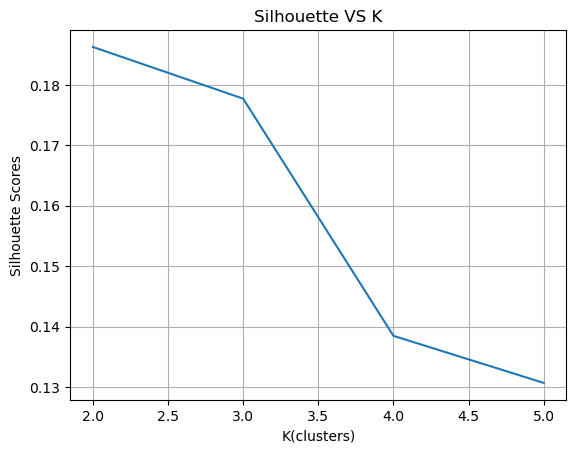

In [45]:
plt.plot(k, w2v_silhouette_scores_agg)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

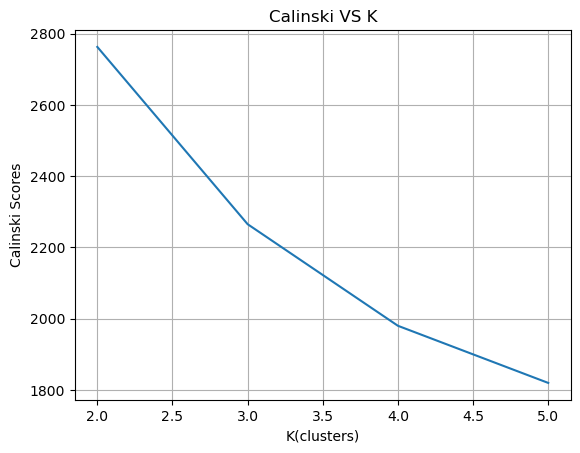

In [46]:
plt.plot(k, w2v_calinski_score_agg)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

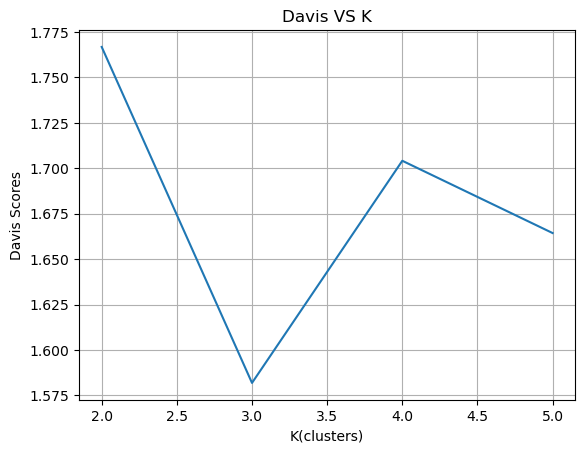

In [47]:
plt.plot(k, w2v_davies_score_agg)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

In [48]:
# Scelto il k ottimale, definisco il clustering

agg_w2v = AgglomerativeClustering(n_clusters=3)
labels_w2v_agg = agg_w2v.fit_predict(x_agg_w2v)

print(sklearn.metrics.silhouette_score(x_agg_w2v, labels_w2v_agg))
print(sklearn.metrics.calinski_harabasz_score(x_agg_w2v, labels_w2v_agg))
print(sklearn.metrics.davies_bouldin_score(x_agg_w2v, labels_w2v_agg))

0.17771693
2265.203461042847
1.5818538659957484


In [49]:
agg_w2v_1,agg_w2v_2,agg_w2v_3=[],[],[]
for i in range(agg_w2v.labels_.shape[0]):
    if agg_w2v.labels_[i] == 0:
        agg_w2v_1.append(x_clust_agg[i])
    elif agg_w2v.labels_[i] == 1:
        agg_w2v_2.append(x_clust[i])
    else:
        agg_w2v_3.append(x_clust_agg[i])

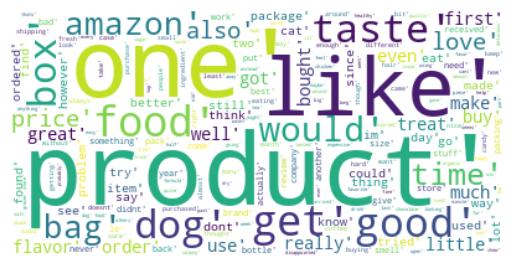

In [50]:
# Cluster 1
data=''
for i in agg_w2v_1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

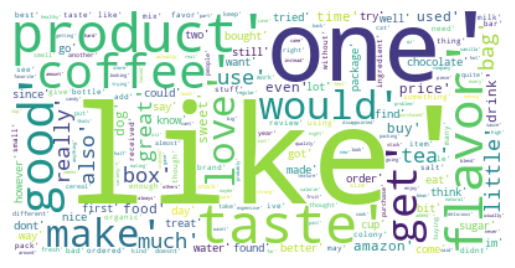

In [51]:
# Cluster 2
data=''
for i in agg_w2v_2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

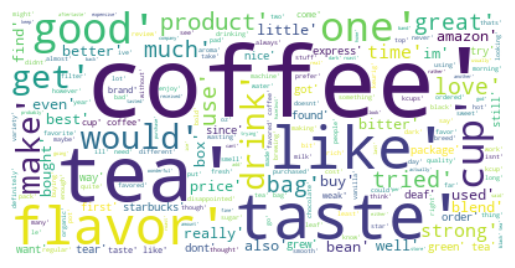

In [52]:
# Cluster 3
data=''
for i in agg_w2v_3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [53]:
cluster_list = [agg_w2v_1,agg_w2v_2,agg_w2v_3]
print("Top 5 terms per cluster:")
for i in range(3):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: product like one food dog
Cluster 2: like taste product one good
Cluster 3: coffee tea taste like cup


# Conclusioni

### K-means

- A seconda delle varie rappresentazioni, il numero ottimale di clusters nel caso di k-means risulta essere fra i 3 e i 5. In ogni caso, sia guardando le metriche valutative non supervisionate utilizzate, sia valutando qualitativamente le parole caratteristiche dei vari cluster, si nota come non esista una suddivisione netta dei dati in cluster ben definiti. In particolare i coefficienti di Silhouette vicini a 0 suggeriscono come i cluster tendano a sovrapporsi.

# Idee successive e utils

- Link utili

Misure di performance: https://analyticsindiamag.com/a-tutorial-on-various-clustering-evaluation-metrics/